# Rule-based Classifier

In [77]:
import pandas as pd
import numpy as np

We import the dataset already splitted.

In [78]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
train_labels = np.ravel(train_labels)

test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

## Preprocessing Pipeline

In [79]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline 


In [80]:
columns_to_drop = ['_url', 'name',  'profile', 'length',
                            'startlist_quality', 'position', 'cyclist', 'cyclist_team', 
                            'duration', 'cyclist_experience_profile',
                            'cyclist_experience_length', 'cyclist_experience_climb', 
                            'avg_rel_position_length', 'avg_rel_position_climb', 
                            'relative_position_sum', 'relative_position',
                            "climb_cat", "length_cat", "cyclist_number", 
                            "avg_rel_position_profile", "points", 'is_tarmac', 
                            'avg_cyclist_level']

In [81]:
train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [82]:
train_data.columns

Index(['climb_total', 'cyclist_age', 'cyclist_level', 'cyclist_experience',
       'avg_relative_position', 'position_entropy', 'top_20_entropy'],
      dtype='object')

Given that this model supports both categorical and numerical features, in the various attempts to find the best model, combinations of both were tried out. This is why the pipeline also supports categorical features.

In [83]:
cat_features = [col for col in ['is_tarmac', 'length_cat', 'climb_cat'] if col not in columns_to_drop]
# Define the preprocessing for numeric and categorical features
numeric_features = [col for col in train_data.columns if col not in cat_features]

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')

# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_features),
        ('cat', 'passthrough', cat_features)
    ]
)

## RIPPER Model

In [84]:
import wittgenstein as lw
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, get_scorer, make_scorer
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score, precision_with_zero_division, recall_with_zero_division
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline


We user RIPPER rule based classifier combined with a random search of the hyperparameters due to the large number of possible combinations and the slow training time of the model.

In [85]:

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('resampling', RandomUnderSampler(random_state=42)),
                       ('classifier', lw.RIPPER(random_state=42))])
param_grid = {
    'classifier__prune_size': [0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__dl_allowance': [0.1, 0.2, 0.3, 0.4, 0.5],
    'classifier__k': [2, 3, 4, 5, 6, 7, 8, 9, 10],
}

scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': make_scorer(precision_with_zero_division),
    'recall': make_scorer(recall_with_zero_division),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1"),
}

#random grid
random_search = RandomizedSearchCV(pipe, 
                                   param_distributions=param_grid, 
                                   n_iter=50, 
                                   cv=5, verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1,
                                   scoring=scoring, 
                                   refit='f1',
                                   return_train_score=True)
random_search.fit(train_data, train_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END classifier__dl_allowance=0.5, classifier__k=2, classifier__prune_size=0.5; total time= 2.3min
[CV] END classifier__dl_allowance=0.5, classifier__k=2, classifier__prune_size=0.5; total time= 2.7min
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time= 2.7min
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time= 2.8min
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time= 3.3min
[CV] END classifier__dl_allowance=0.5, classifier__k=2, classifier__prune_size=0.5; total time= 5.6min
[CV] END classifier__dl_allowance=0.5, classifier__k=2, classifier__prune_size=0.5; total time= 5.9min
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time= 6.6min
[CV] END classifier__dl_allowance=0.1, classifier__k=3, classifier__prune_size=0.5; total time= 6.9min
[CV] END cl

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['climb_total',
                                                                                'cyclist_age',
                                                                                'cyclist_level',
                                                                                'cyclist_experience',
                                                                                'avg_relative_position',
                                                                                'position_entropy',
                                                                                'top_20_entropy']),
                                                                              ('cat',
                                                                               'passthrough',
                                                                               [])])),
                                             ('resampling',
                                              RandomUnderSampler(random_state=42)),
                                             ('classifier',
                                              <RIPPER...
                            'precision': make_scorer(precision_with_zero_division, response_method='predict'),
                            'recall': make_scorer(recall_with_zero_division, response_method='predict'),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(sensitivity_score, response_method='predict'),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=2)

## Model Assessment

### Training scores:

In [86]:
# extract the results of the randomized search and best model idx
cv_results = random_search.cv_results_
best_model = random_search.best_estimator_
best_index = random_search.best_index_

#extract and print matrics
mean_train_scores = {metric: cv_results[f'mean_train_{metric}'][best_index] for metric in scoring.keys()}
std_train_scores = {metric: cv_results[f'std_train_{metric}'][best_index] for metric in scoring.keys()}

print("Training results of the best model:")
for metric in scoring.keys():
    print(f"{metric.capitalize()} - Mean: {mean_train_scores[metric]:.4f}, Std: {std_train_scores[metric]:.4f}")


Training results of the best model:
Sensitivity - Mean: 0.5743, Std: 0.0044
Specificity - Mean: 0.7743, Std: 0.0031
Accuracy - Mean: 0.7477, Std: 0.0033
Precision - Mean: 0.2804, Std: 0.0042
Recall - Mean: 0.5743, Std: 0.0044
Roc_auc - Mean: 0.6869, Std: 0.0038
F1 - Mean: 0.3768, Std: 0.0048


### Validation scores

In [87]:
# extract the results of the randomized search and best model idx
cv_results = random_search.cv_results_
best_model = random_search.best_estimator_
best_index = random_search.best_index_

#extract and print matrics
mean_test_scores = {metric: cv_results[f'mean_test_{metric}'][best_index] for metric in scoring}
std_test_scores = {metric: cv_results[f'std_test_{metric}'][best_index] for metric in scoring}

print("Validation results of the best model:")
for metric in scoring:
    print(f"{metric.capitalize()} - Mean: {mean_test_scores[metric]:.4f}, Std: {std_test_scores[metric]:.4f}")



Validation results of the best model:
Sensitivity - Mean: 0.5747, Std: 0.0334
Specificity - Mean: 0.7734, Std: 0.0322
Accuracy - Mean: 0.7470, Std: 0.0254
Precision - Mean: 0.2819, Std: 0.0224
Recall - Mean: 0.5747, Std: 0.0334
Roc_auc - Mean: 0.6868, Std: 0.0144
F1 - Mean: 0.3773, Std: 0.0201


### Test scores

Accuracy: 0.63
Recall: 0.749
Precision: 0.248
Sensitivity: 0.749
Specificity: 0.609
F1 Score: 0.372
ROC AUC Score: 0.679


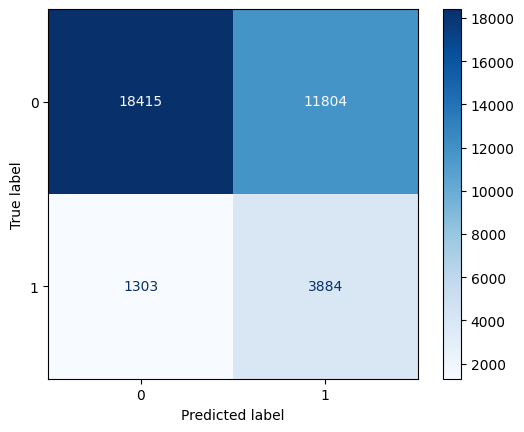

In [88]:

# Predict on the test data
test_predictions = random_search.predict(test_data)

# Calculate and visualize evaluation metrics
accuracy = round(accuracy_score(test_labels, test_predictions), 3)
recall = round(recall_with_zero_division(test_labels, test_predictions), 3)
precision = round(precision_with_zero_division(test_labels, test_predictions), 3)
sensitivity_score = round(sensitivity_score(test_labels, test_predictions), 3)
specificity_score = round(specificity_score(test_labels, test_predictions), 3)
f1 = round(f1_score(test_labels, test_predictions), 3)
roc_auc = round(roc_auc_score(test_labels, test_predictions), 3)
conf_matrix = confusion_matrix(test_labels, test_predictions)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity_score}")
print(f"Specificity: {specificity_score}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [89]:
report = classification_report(test_labels, test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.61      0.74     30219
           1       0.25      0.75      0.37      5187

    accuracy                           0.63     35406
   macro avg       0.59      0.68      0.55     35406
weighted avg       0.83      0.63      0.68     35406



## Save Results

In [90]:
import sys
sys.path.append('..')
from utils import save_results

resampling = "under"   # "no", "under", "over", "smotetomek"
save_results('rule_based', resampling, mean_train_scores, std_train_scores, mean_test_scores, std_test_scores, accuracy, recall, precision, sensitivity_score, specificity_score, f1, roc_auc, report)

## Model Save

In [91]:
import joblib
import os

# Create the directory if it doesn't exist
os.makedirs('best_models', exist_ok=True)
# Save the best model
joblib.dump(best_model, 'best_models/rule_based.pkl')

['best_models/rule_based.pkl']

### Rule Extraction

In [94]:
import joblib
import wittgenstein
# load the best RIPPER model
best_model = joblib.load('best_models/rule_based.pkl')

#extract the rules
rules = best_model.named_steps['classifier'].ruleset_.rules

# Print the rules
for i, rule in enumerate(rules):
    print(f"Rule {i + 1}:")
    print(rule)
    print()



Rule 1:
[6=>1.59]

Rule 2:
[6=1.37-1.59]

Rule 3:
[6=1.07-1.37]

Rule 4:
[6=0.75-1.07]

Rule 5:
[6=0.42-0.75]



Now we make the rules more interpretable.

In [93]:
import re

# fit the scaler to the training data
num_transformer.fit(train_data[numeric_features])

# extract mean and variance from the scaler
mean = num_transformer.mean_
std = np.sqrt(num_transformer.var_)

# function to easily denormalize a value
def denormalize(normalized_value, feature_index):
    return round((normalized_value * std[feature_index]) + mean[feature_index], 2)

# create a dict of feature names
feature_names = list(test_data.columns)
feat_names = {
    6 : feature_names[6],
    1 : feature_names[1],
    4 : feature_names[4]
}

# create a key-value pair of values to replace with its denormalized value (since it is a bit tricky to deal with the strings)
feat_values = {
    1.53: denormalize(1.53, 6),
    1.25: denormalize(1.25, 6),
    0.89: denormalize(0.89, 6),
    -0.43: denormalize(-0.43, 1),
    -0.17: denormalize(-0.17, 1),
    -1.42: denormalize(-1.42, 4),
    -1.03: denormalize(-1.03, 4)
}


# for each rule, substitute the feature index with the feature name
for i, rule in enumerate(rules):
    rule_str = str(rule)
    for key, value in feat_names.items():
        rule_str = rule_str.replace(f"[{key}=", f"[{value}=")
        rule_str = rule_str.replace(f"^{key}=", f"^{value}=")

    # replace the feature values with the denormalized values
    for k, v in feat_values.items():
        rule_str = rule_str.replace(str(k), str(v))
    
    # replace ^ with AND and put a space before and after
    rule_str = re.sub(r'\^', ' AND ', rule_str)
        
    print(f"Rule {i + 1}:")
    print(rule_str)
    print()

Rule 1:
[top_20_entropy=>1.59]

Rule 2:
[top_20_entropy=1.37-1.59]

Rule 3:
[top_20_entropy=1.07-1.37]

Rule 4:
[top_20_entropy=0.75-1.07]

Rule 5:
[top_20_entropy=0.42-0.75]



**Interpretation**

The model has extracted 5 rules to classify the top 20 cyclists, using only ```top_20_entropy```. The rules are the following:

- **Rule 1**: when the entropy of top 20 cyclists is greater or equal than 1.59, the model captures instances where variability among the top 20 cyclists is high.

Same reasoing applies to other rules but at this time the entropy value is bounded:
- **Rule 2**: the entropy value is bounded by 1.37 and 1.59
- **Rule 3**: the entropy value is bounded between 1.07 and 1.37
- **Rule 4**: the entropy value is bounded between 0.75 and 1.07
- **Rule 5**: the entropy value is bounded between 0.42 and 0.75

As we quite expected, the model focuses mainly on the feature mostly related to the target variable. However the rules seems not really udeful since there is a lower bound and no upper bound for the entropy value, making the rules able only to classify only the cyclist with higher entropy. Instead we want the converse behaviour. s we highlited in the extra analysis, the mutual information we printed between the feature and the labels is higher for ```top_20_entropy``` so we suppose this is the reason why the model tends to use more this feature.

## Results

The classifier showed significantly better performance when using undersampling compared to no resampling. Undersampling provided a higher validation F1 score of 0.3773 and a ROC AUC of 0.6868, indicating a more balanced trade-off between precision and recall, as well as better class discrimination. On the test set, undersampling continued to demonstrate improved performance with an F1 score of 0.372 and a ROC AUC of 0.679, suggesting reasonable model generalization. In contrast, no resampling resulted in a low validation F1 score of 0.0903 and a ROC AUC of 0.5217, showing that the model struggled to correctly identify the minority class without balancing techniques.

Unfortunately, we were not able to test all the sampling techniques due to the long training time of the model.

